<a href="https://colab.research.google.com/github/jjsilvera/data-science-portfolio/blob/main/Generador_de_series_temporales_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code implements a conditional Wasserstein Generative Adversarial Network with gradient penalty (WGAN-GP) model to generate synthetic temperature time series.

# A generative network (Generator) is trained to produce realistic temperature sequences based on the most recently observed real values.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
# ---------------------------
# 1) Load data
# ---------------------------
df = pd.read_csv('/content/drive/MyDrive/temperature_data.csv')
scaler = MinMaxScaler(feature_range=(-1, 1))
temperature_scaled = scaler.fit_transform(df[['Temperature']].values).flatten()
# This normalises values to the range [-1, 1], which makes neural network training more stable (especially with tanh functions).

In [ ]:
# ---------------------------
# 2) Parameters
# ---------------------------
seq_length = 30            # length of the complete sequence
cond_len = 10              # how many actual steps condition the generator
assert cond_len < seq_length
input_dim = 1
hidden_dim = 128
batch_size = 32
num_epochs = 600
pretrain_epochs = 100
n_critic = 5
lambda_gp = 10.0
lambda_recon = 5.0

In [ ]:
# ---------------------------
# 3) Dataset
# ---------------------------
class TimeSeriesDataset(Dataset):
  """Split the continuous series into sliding windows (subsequences) of length seq_length"""
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, i):
        window = self.data[i:i+self.seq_length]           # Sequence of length seq_length
        return torch.tensor(window, dtype=torch.float32).unsqueeze(-1)

dataset = TimeSeriesDataset(temperature_scaled, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# ---------------------------
# 4) Models
# ---------------------------
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()   # Output [-1,1]
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        h0 = torch.zeros(2, x.size(0), hidden_dim, device=x.device)
        c0 = torch.zeros(2, x.size(0), hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))            # (batch, seq_len, hidden_dim)
        out = self.fc(out)                         # (batch, seq_len, output_dim)
        return out


class Critic(nn.Module): # (Discriminator)
"""Evaluates whether a sequence is real or generated"""
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)        # Output scalar (Wasserstein score)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), hidden_dim, device=x.device)
        c0 = torch.zeros(2, x.size(0), hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))           # (batch, seq_len, hidden_dim)
        last = out[:, -1, :]                      # Take last temporary status
        score = self.fc(last)                     # (batch, 1)
        return score

generator = Generator(input_dim, hidden_dim, input_dim).to(device)
critic = Critic(input_dim, hidden_dim).to(device)

In [ ]:
# ---------------------------
# 5) Optimizers
# ---------------------------
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.9))
c_optimizer = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))

mse_loss = nn.MSELoss()

In [ ]:
# ---------------------------
# 6) Gradient function
# ---------------------------
def gradient_penalty(critic, real, fake, device="cpu"):
    # Interpolates between real and fake data.
    alpha = torch.rand(real.size(0), 1, 1, device=device)
    interp = alpha * real + (1 - alpha) * fake
    interp.requires_grad_(True)
    prob = critic(interp)
    grads = torch.autograd.grad(
        outputs=prob,
        inputs=interp,
        grad_outputs=torch.ones_like(prob, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]  # (batch, seq_len, input_dim)
    grads = grads.view(grads.size(0), -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [ ]:
# ---------------------------
# 7) Generator pre-training (supervised) - optional
# Train the generator as an autoencoder: try to reconstruct real sequences
# ---------------------------
print("Preentrenamiento del generador (MSE)...")
g_pre_opt = optim.Adam(generator.parameters(), lr=1e-3)
for epoch in range(pretrain_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)                           # (B, seq_len, 1)
        g_pre_opt.zero_grad()
        pred_seq = generator(batch)
        # This penalizes the complete prediction with the actual sequence
        loss = mse_loss(pred_seq, batch)
        loss.backward()
        g_pre_opt.step()
        epoch_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Pretrain epoch {epoch+1}/{pretrain_epochs} - loss: {epoch_loss/len(dataloader):.6f}")
print("Preentrenamiento finalizado.\n")

Preentrenamiento del generador (MSE)...
Pretrain epoch 20/100 - loss: 0.003021
Pretrain epoch 40/100 - loss: 0.000815
Pretrain epoch 60/100 - loss: 0.000465
Pretrain epoch 80/100 - loss: 0.000418
Pretrain epoch 100/100 - loss: 0.000382
Preentrenamiento finalizado.



In [ ]:
# ---------------------------
# 8) Conditional WGAN-GP training
# ---------------------------
print("Entrenamiento WGAN-GP condicional...")
for epoch in range(num_epochs):
    c_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, real_batch in enumerate(dataloader):
        real_batch = real_batch.to(device)   # (B, seq_len, 1)

        # --------------------
        # 1) Update critic n_critic times
        # --------------------
        for _ in range(n_critic):
            c_optimizer.zero_grad()
            # Prepare conditional input: take last cond_len actual steps
            context = real_batch[:, :cond_len, :]                             # (B, cond_len, 1)
            noise_future = torch.randn(real_batch.size(0), seq_length - cond_len, input_dim, device=device)
            gen_input = torch.cat([context, noise_future], dim=1)             # (B, seq_len, 1)
            fake_batch = generator(gen_input).detach()                        # (B, seq_len, 1)

            # Critic outputs
            c_real = critic(real_batch)
            c_fake = critic(fake_batch)

            gp = gradient_penalty(critic, real_batch, fake_batch, device=device)
            c_loss = (c_fake.mean() - c_real.mean()) + lambda_gp * gp

            c_loss.backward()
            c_optimizer.step()

        # --------------------
        # 2) Update generator
        # --------------------
        g_optimizer.zero_grad()
        # Conditional
        context = real_batch[:, :cond_len, :]
        noise_future = torch.randn(real_batch.size(0), seq_length - cond_len, input_dim, device=device)
        gen_input = torch.cat([context, noise_future], dim=1)
        fake_batch = generator(gen_input)               # (B, seq_len, 1)

        # Adversarial loss (Wasserstein)
        g_adv = -critic(fake_batch).mean()
        # Reconstruction loss so that the sequence does not stray too far
        g_recon = mse_loss(fake_batch, real_batch)
        g_loss = g_adv + lambda_recon * g_recon

        g_loss.backward()
        g_optimizer.step()

        c_loss_epoch += c_loss.item()
        g_loss_epoch += g_loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]  Critic loss: {c_loss_epoch/len(dataloader):.4f}  Generator loss: {g_loss_epoch/len(dataloader):.4f}")

print("Entrenamiento completado.\n")


Entrenamiento WGAN-GP condicional...
Epoch [10/600]  Critic loss: -0.1036  Generator loss: 0.8185
Epoch [20/600]  Critic loss: -0.0551  Generator loss: 0.0011
Epoch [30/600]  Critic loss: 0.0334  Generator loss: -0.1895
Epoch [40/600]  Critic loss: 0.0268  Generator loss: -0.2395
Epoch [50/600]  Critic loss: 0.0106  Generator loss: -0.1921
Epoch [60/600]  Critic loss: 0.0236  Generator loss: -0.2285
Epoch [70/600]  Critic loss: 0.0212  Generator loss: -0.2070
Epoch [80/600]  Critic loss: 0.0159  Generator loss: -0.2203
Epoch [90/600]  Critic loss: 0.0122  Generator loss: -0.1914
Epoch [100/600]  Critic loss: 0.0130  Generator loss: -0.1496
Epoch [110/600]  Critic loss: 0.0174  Generator loss: -0.0977
Epoch [120/600]  Critic loss: 0.0138  Generator loss: -0.0737
Epoch [130/600]  Critic loss: 0.0156  Generator loss: -0.0738
Epoch [140/600]  Critic loss: 0.0032  Generator loss: 0.0065
Epoch [150/600]  Critic loss: 0.0072  Generator loss: 0.0237
Epoch [160/600]  Critic loss: 0.0029  Genera

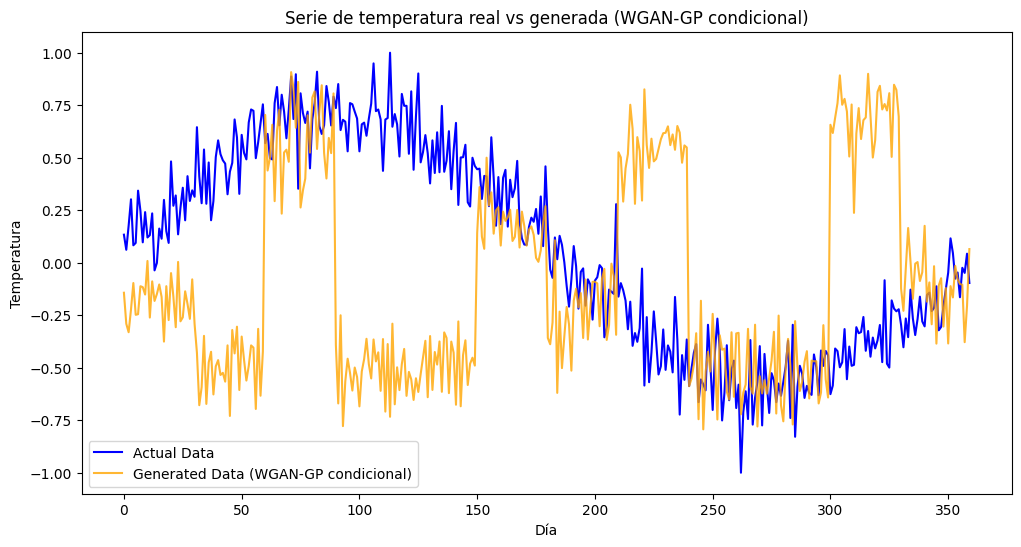

In [ ]:
# ---------------------------
# 9) Generation and visualization
# ---------------------------
# Generate sequences by concatenating several random contextual seeds to produce a long series.
num_seq = len(temperature_scaled) // seq_length
generated = []
gen_samples = []

# Random contexts from the dataset
for idx in np.random.choice(len(dataset), size=num_seq, replace=False):
    context = dataset[idx][:cond_len].unsqueeze(0).to(device)   # (1, cond_len, 1)
    noise_future = torch.randn(1, seq_length - cond_len, input_dim, device=device)
    gen_input = torch.cat([context, noise_future], dim=1)
    fake_seq = generator(gen_input).detach().cpu().numpy().reshape(-1)
    generated.append(fake_seq)
    gen_samples.extend(fake_seq.tolist())

generated = np.array(generated).reshape(-1)
generated_rescaled = scaler.inverse_transform(generated.reshape(-1,1)).flatten()
actual_rescaled = df['Temperature'].values[:len(generated_rescaled)]

plt.figure(figsize=(12,6))
plt.plot(actual_rescaled, label='Actual Data', color='blue')
plt.plot(generated_rescaled, label='Generated Data (WGAN-GP condicional)', color='orange', alpha=0.8)
plt.title('Serie de temperatura real vs generada (WGAN-GP condicional)')
plt.xlabel('Día')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

The training reached a point of equilibrium (adversarial convergence).
  

*   The critic and generator are balanced—neither dominates
*   The model has learned a representation of the temporal dynamics, and the stable values (between -0.1 and 0.1) indicate that the Wasserstein distance is minimal, which means:
 “The generated and real series come from very similar distributions.”

In other words:


*   The critic can no longer distinguish well between the two.
*   The generator produces sequences that are consistent with the dynamics of the original set.

*   The generated curves will probably appear smooth and consistent with the seasons, although perhaps with less variability than real ones.







